# Programming Challenge


Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import graphviz 

# Results comparisson

In [8]:
gt = np.loadtxt("./content/EvaluationGT-6.csv", encoding="utf-8", dtype="str")
results = np.loadtxt("./output/results.txt", encoding="utf-8", dtype="str")

print("Accuracy:","%.5g" % (100*np.mean((results==gt).astype(float))) )

Accuracy: 62.61


# Preprocessing

load csv and apply the following changes
1. remove column 5
2. encode the labels as 0: Serpent, 1: Dragspel, 2: Nyckelharpa
3. replace N/A by ''
4. transform boolean column into TRUE: 1, and FALSE: 0

In [3]:
def label_encodings(label):
    if label == "Serpent":
        return 0
    elif label == "Dragspel":
        return 1
    else:
        return 2


# na_transform = lambda s: '' if s == 'N/A' else s
bool_transform = lambda b: 1 if b == 'TRUE' else 0

# data_types = [("y", "U11"), ("x1", np.float32), ("x2", np.float32), ("x3", np.float32), ("x4", np.float32), ("x5", np.float32), ("x6", "U17"), ("x7", np.float32), ("x8", np.float32), ("x9", np.float32), ("x10", np.float32), ("x11", np.float32), ("x12", np.float32), ("x13", np.float32)]
# Get all string features
labels, x6_raw = np.genfromtxt("./content/TrainOnMe-Clean.csv", delimiter=";", encoding="utf-8", dtype=None, skip_header=1, usecols=[0, 6], converters={0: label_encodings}, unpack=True)
# Get all float features
data_raw = np.loadtxt("./content/TrainOnMe-Clean.csv", delimiter=";", encoding="utf-8", skiprows=1, usecols=[1,2,3,4,7,8,9,10,11,12,13], converters = {11: bool_transform, 12: bool_transform})

In [ ]:
display(labels)
display(x6_raw)

### Normalize the float data

boolean data needs to be added back in
**ONLY USE FOR SVM; REMEMBER TO CHANGE INPUTS FOR PCA**

In [4]:
# data_normed = normalize(data_raw, axis=0) # rewrite the boolean columsn that get ruined by the normalization
def normalize(input):
    scalar = StandardScaler().fit(input)
    normed = scalar.transform(input)
    normed[:, -3] = input[:, -3]
    normed[:, -2] = input[:, -2]
    return normed
data_normed = normalize(data_raw)

In [ ]:
print(data_normed[:10])

### One-hot encoding of x6 categorial features

- first get the categories (including N/A)
- second encode them

In [5]:
def x6_encoding(input, x6):
    categories = set(x6)
    # categories.remove('N/A')
    categories = list(categories)

    encoder = OneHotEncoder(handle_unknown='ignore', categories=[categories,])
    # fit and transform x6 using the encoder
    x6_encoded = encoder.fit_transform(x6.reshape(-1, 1)) # reshape to make it column vector (comes as )
    x6_encoded = x6_encoded.todense()

    return np.asarray(np.hstack((input, x6_encoded)))

In [195]:
data_encoded = x6_encoding(data_raw, x6_raw)

In [6]:
data_encoded = x6_encoding(data_normed, x6_raw)

In [6]:
print(data_encoded.shape)
print(data_encoded[0])

(996, 18)
[-6.61910000e-01  2.27075098e+03  1.00087802e+03  6.65212700e+01
 -1.10984000e+00  1.61928000e+00  5.47863564e+03 -8.91877781e+04
  1.00000000e+00  1.00000000e+00  1.32381000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


## PCA

In [7]:
def run_pca(input):
    pca = PCA(n_components=7)
    pca.fit(input)
    return pca.transform(input)
data = run_pca(data_encoded)
print(data.shape)

(996, 7)


# Classifier

In [241]:
clf = SVC()
# clf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=7, ccp_alpha=0.004)
clf.fit(X=data, y=labels)
prediction = clf.predict(data)
print("Accuracy","%.3g" % (100*np.mean((prediction==labels).astype(float))))

Accuracy 77.1


# Evaluation

Prepare the data

In [242]:
# Get all string features
x6_eval = np.genfromtxt("./content/EvaluateOnMe-6.csv", delimiter=",", encoding="utf-8", dtype=None, skip_header=1, usecols=[5])
# Get all float features
input_eval = np.loadtxt("./content/EvaluateOnMe-6.csv", delimiter=",", encoding="utf-8", skiprows=1, usecols=[0,1,2,3,6,7,8,9,10,11,12], converters = {10: bool_transform, 11: bool_transform})

data_encoded = x6_encoding(normalize(input_eval), x6_eval)
# data_encoded = x6_encoding(input_eval, x6_eval)
print(data_encoded.shape)
data_eval = run_pca(data_encoded)
print(data_eval.shape)

(10000, 18)
(10000, 8)


Run the classification

In [243]:
def reencode_labels(results):
    def encodings(x):
        if x == 0:
            return "Serpent"
        elif x == 1:
            return "Dragspel"
        else:
            return "Nyckelharpa"
    return [encodings(x) for x in results]

result = clf.predict(data_eval)
result = reencode_labels(result)
print(len(result))

10000


Output to file

In [244]:
with open('./output/results.txt','w') as tfile:
    tfile.write('\n'.join(result))

# Test Classifier

classification and testing steps put together in a loop

In [16]:
def test_classifier(data, labels, ntrials = 100): 
    means = np.zeros(ntrials,)
    for trial in range(ntrials):
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

        # Train
        # clf = DecisionTreeClassifier(criterion="entropy", max_depth=6, ccp_alpha=0.006)
        clf = SVC()
        # clf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=8, ccp_alpha=0.003)
        clf.fit(X=X_train, y=y_train)
        # Predict
        prediction = clf.predict(X_test)

        # Compute classification error
        if trial % 10 == 0:
            print("Trial:",trial,"Accuracy","%.3g" % (100*np.mean((prediction==y_test).astype(float))) )

        means[trial] = 100*np.mean((prediction==y_test).astype(float))

    print("Final mean classification accuracy ", "%.3g" % (np.mean(means)), "with standard deviation", "%.3g" % (np.std(means)))

In [17]:
test_classifier(data, labels, ntrials=100)

Trial: 0 Accuracy 71.6
Trial: 10 Accuracy 70.9
Trial: 20 Accuracy 77.6
Trial: 30 Accuracy 74.6
Trial: 40 Accuracy 72.2
Trial: 50 Accuracy 69.6
Trial: 60 Accuracy 70.6
Trial: 70 Accuracy 73.2
Trial: 80 Accuracy 69.2
Trial: 90 Accuracy 70.9
Final mean classification accuracy  72 with standard deviation 2.11


## Test Relevance of Features

In [ ]:
n_data, n_features = data.shape
for x in range(n_features):
  # sel = range(len(features) - x)
  print(f"Predictive power of feature f{x}:")
  test_classifier(data[:, x].reshape(-1, 1), labels, ntrials=10)


In [ ]:
n_data, n_features = data.shape
for x in range(n_features):
  sel = list(range(n_features - x))
  sel = [abs(x-17) for x in sel]
  print(f"Predictive power of feature {sel}:")
  test_classifier(data[:, sel], labels, ntrials=30)

## Experimenting with tree parameters

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
clf = DecisionTreeClassifier(criterion="gini")
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier()

Number of nodes in the last tree is: 1 with ccp_alpha: 0.08154430978601412


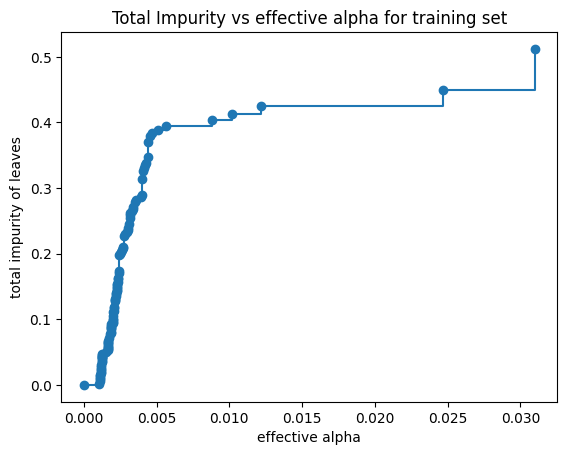

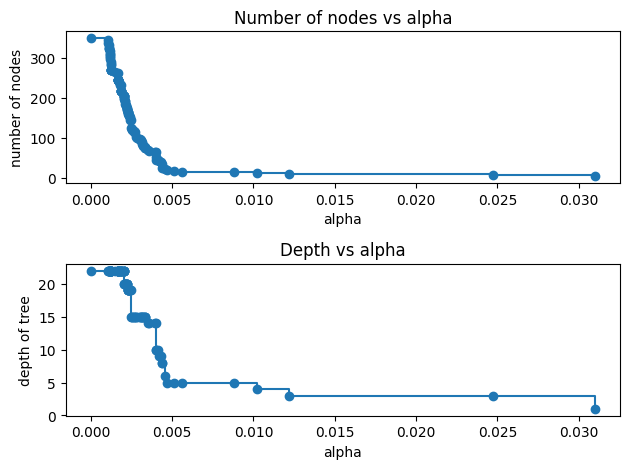

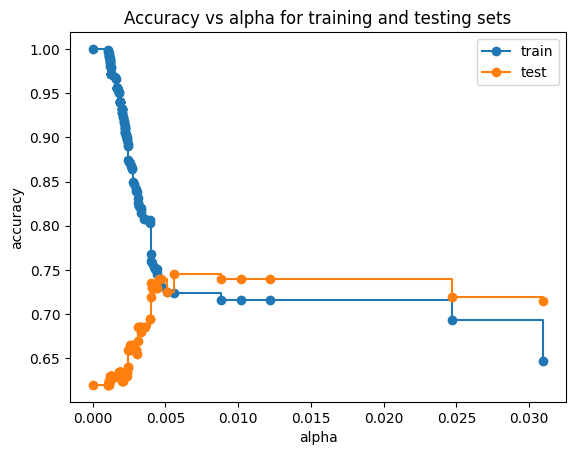

In [40]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# prova

dot_data = export_graphviz(clf, out_file=None,class_names=["Serpent","Dragspel","Nyckelharpa"],filled=True, rounded=True,special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("pruned_tree")

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
clf = DecisionTreeClassifier(max_depth=7, criterion="gini", ccp_alpha=0.005)
clf.fit(X=X_train, y=y_train)
prediction = clf.predict(X_test)

accuracy = 100*np.mean((prediction==y_test).astype(float))
print(accuracy)

74.0
